In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import sklearn.preprocessing 
import random
import yaml
import h5py
import logging
import datetime
import os
import time

import pprint
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import torch.nn.functional as F


from load_matlab_timedata import get_data_from
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy


## Loading config files, setup execution parameters, init objects

In [2]:
plt.rcParams['figure.figsize'] = 20, 7.
CONFIG_FILENAME = "model_params.yaml"
# ! ls DC_motor_simulation
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
   
pprint.pprint(config)


p_net = config['network_params']

p_train = config['train_params']

p_gen = config['generator_params']

p_data = config['data_params']
need_normalize = p_data['need_normalize']

{'data_params': {'integration_step': 0.01,
                 'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3,
                 'use_part_of_data': 1.0},
 'exp_path': 'only_batches',
 'generator_params': {'a': 0.5, 'b': 1.0, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 32,
                    'input_size': 64,
                    'num_layers': 1,
                    'output_dim': 3,
                    'per_element': True,
                    'retrospective_steps': 128},
 'to_generate_data': False,
 'train_params': {'auto_loss': True,
                  'aux': {'steady_state_threshold': 0.0001},
                  'batch_size': 1024,
                  'drop_lr_each': 5,
                  'learning_rate': 0.001,
                  'loss_fn': 'mse',
                  'lr_drop_rate': 3,
             

# Set parameters

In [3]:

# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']
    
# if is_debug:
#     x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])
to_generate_data = config['to_generate_data'] 
if to_generate_data:
    p_gen = config['generator_params']
    print("Data generator params:")
    pprint.pprint(p_gen)
    a = p_gen['a']
    b = p_gen['b']
is_debug = config['is_debug']


init_logger(config)

logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}") 

logger inited to file [only_batcheslogs/exp_2019-05-02_12:48:58.log]


## Init data loader and get appropriate part of data

using 1.0 of data
X normalized, norms: [14.99712541]
x shaoe (76924,)
x_normalized shaoe (76924, 1)
test (76924, 1)


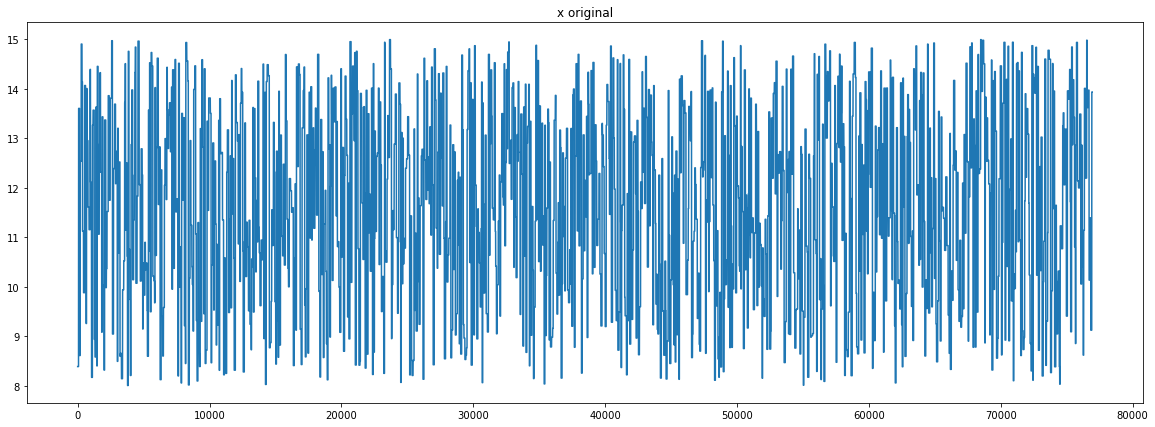

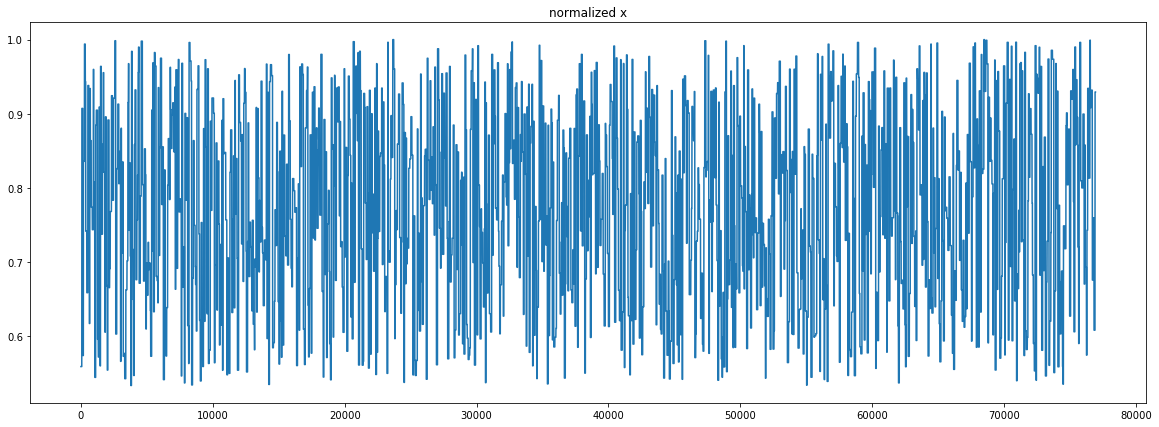

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (23078, 1)
output partition shape (23078, 1)
stacked Y shape  (22950, 1)
Y_tensor torch.Size([22950, 1])
X_tensor torch.Size([128, 22949, 1])
X normalized, norms: [14.99712541]
x shaoe (76924,)
x_normalized shaoe (76924, 1)
test (76924, 1)


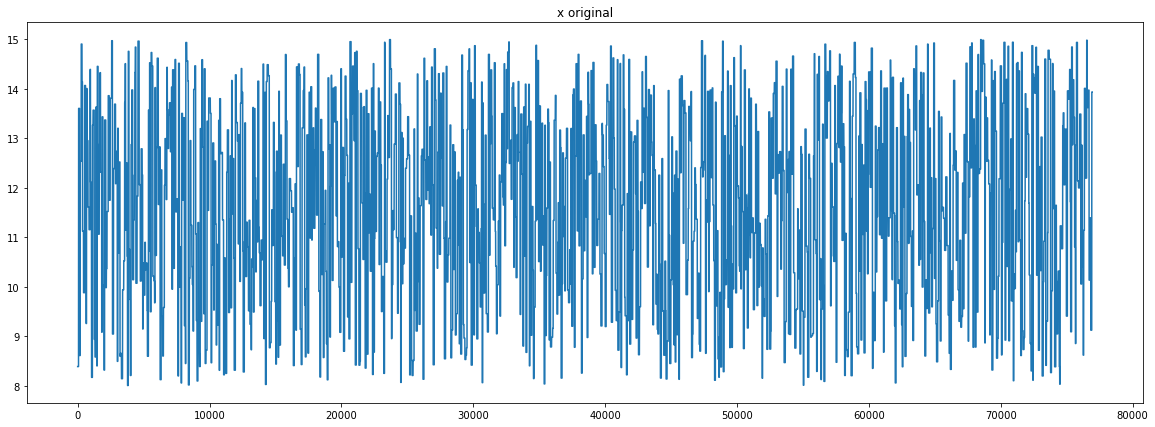

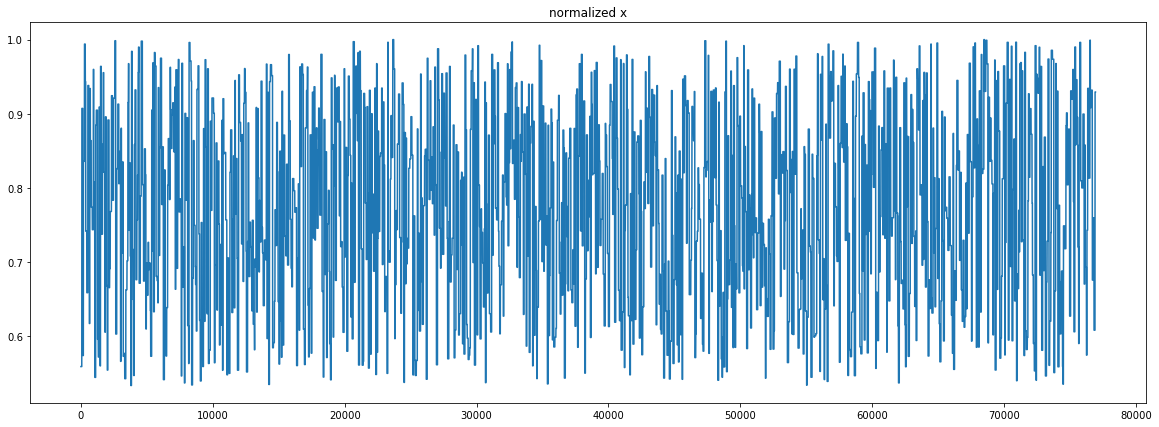

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (53846, 1)
output partition shape (53846, 1)
stacked Y shape  (53718, 1)
Y_tensor torch.Size([53718, 1])
X_tensor torch.Size([128, 53717, 1])
train set: [53718] batches
test set: [22950] batches
data_loading time 21.474451541900635 secs


In [4]:
# todo add time tracking for this cell
use_part = p_data['use_part_of_data']
print(f"using {use_part} of data")

t_tick = time.time()

test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(use_part - use_part*p_data['test_size'], use_part),                        
                               logging=logging)

train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, use_part - use_part*p_data['test_size']),
                                logging=logging)

print(f"train set: [{len(train_ts_ds)}] batches")
print(f"test set: [{len(test_ts_ds)}] batches")

if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms[0]
    config['y_norm'] = train_ts_ds.y_norms[0]
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )    
    
t_tock = time.time()
dataload_time = t_tock - t_tick
print(f"data_loading time {dataload_time} secs")

## Inspecting data we have, get several batches and look inside on pretty large scale to see individual iterations:

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 128, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


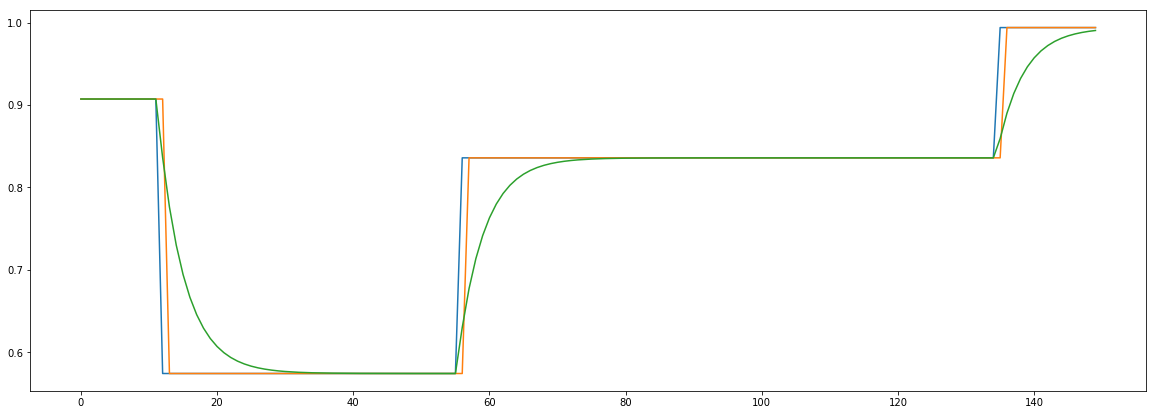

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 128, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


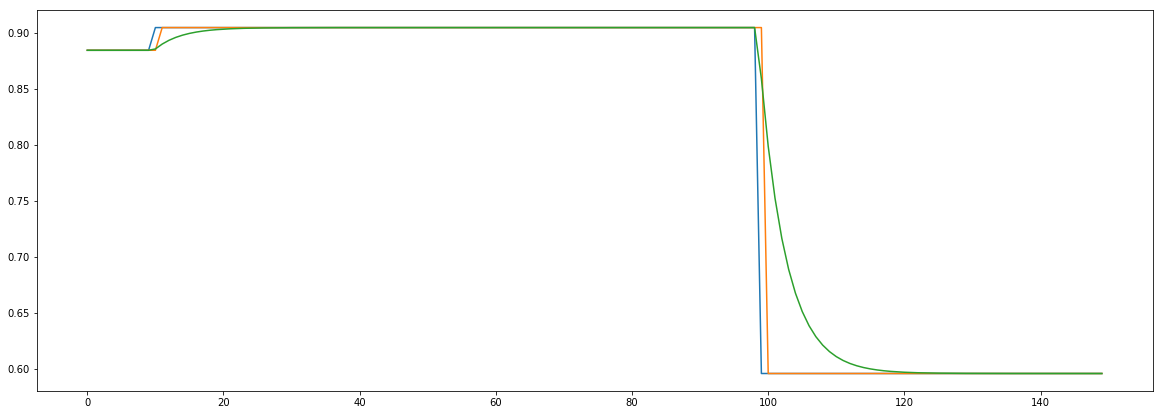

In [5]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x [batch_size, retrospective_steps, channels] :{x.shape}")
    print(f"y [batch_size, channels]: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last [slice_size]: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t])
    plt.plot(x.detach().numpy()[-2][f:t])
    plt.plot(y_kth)
    plt.show()
    if i == 1:
        break

## Creating objects from imported files

In [6]:
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy  # imports here for faster rerun and debug procedure

model = LSTM(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

loss_fn = myLoss

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

if p_train['optimizer'] == "adam":
    lr = p_train['learning_rate']
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

logging.info(f"Model n params: {model.get_num_params()}")
print(f"model has [{model.get_num_params()}] params")
num_epochs = p_train['num_epochs']
logging.info("Training process INITIALIZED")


model has [4579.0] params


In [7]:
# #####################
# # 
# #####################
# from torch.nn import init
# for layer_p in a._all_weights:
#     for p in layer_p:
#         if 'weight' in p:
#             # print(p, a.__getattr__(p))
#             init.normal(a.__getattr__(p), 0.0, 0.02)

In [8]:
logging.info("History INITIALIZED")

hist = {"train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        
        "aux":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        },
        
        "const":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        },
        'preds':{
            '1':np.zeros(num_epochs),
            '2':np.zeros(num_epochs),            
        }
       }

In [9]:
# TODO train function (or trainer class)

## Train model


aux preds: 0.6619963049888611 0.007903652265667915
aux loss 1.3104687798678731
const loss 0.07098119530620842
main loss 0.0
combined loss 1.3814499751740816 


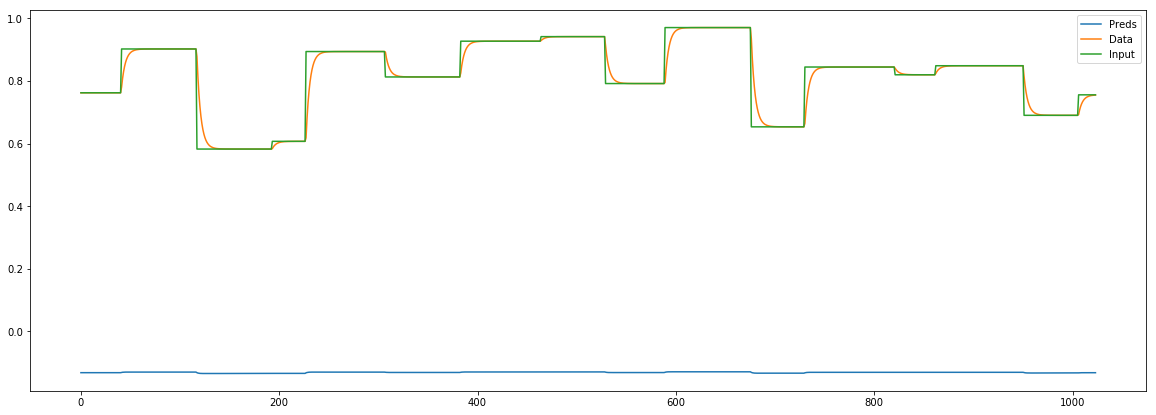

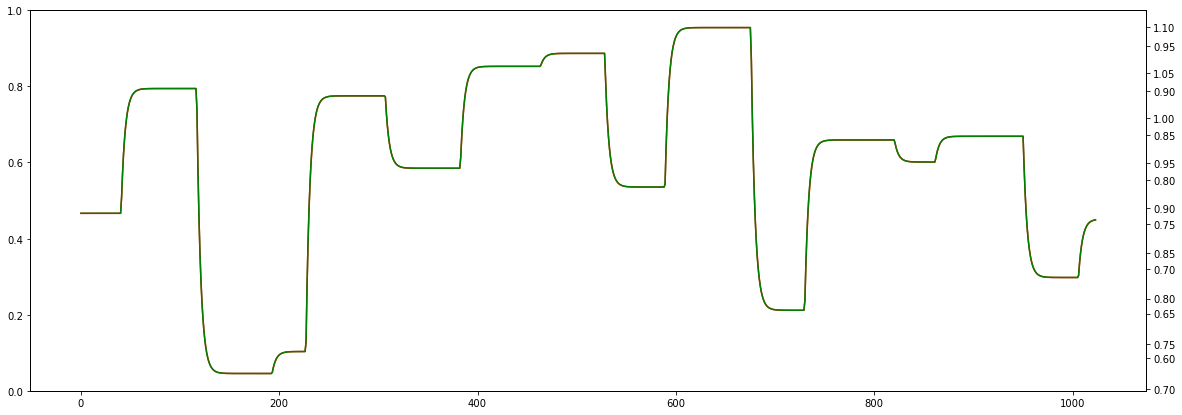

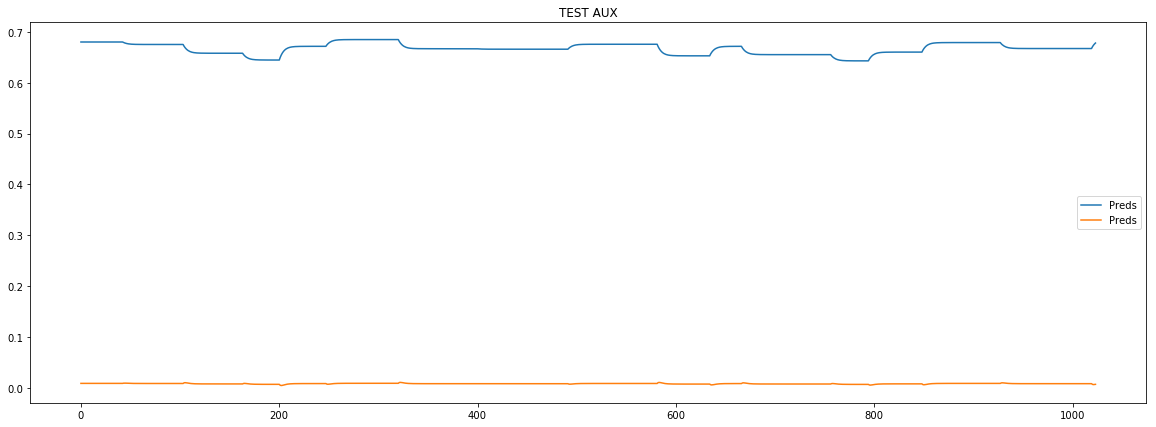

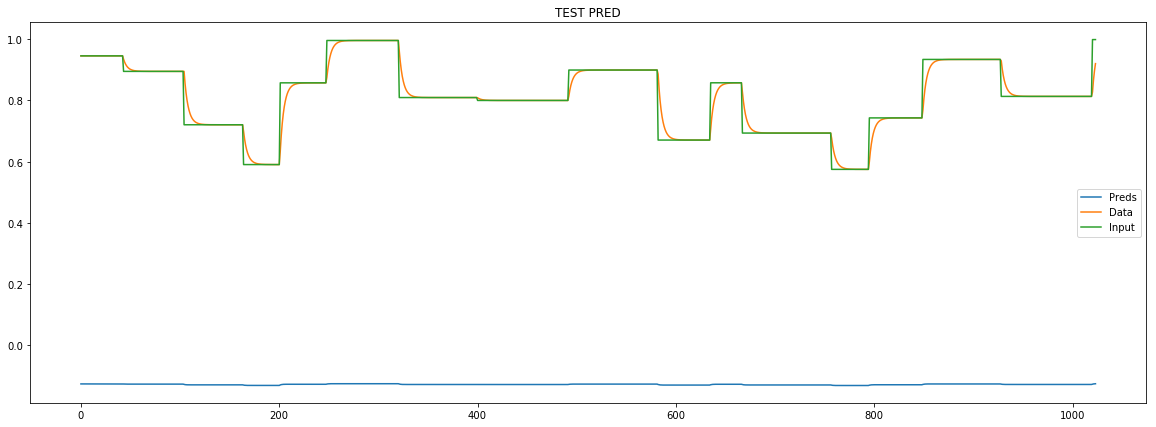

 Epoch [0]     
 train_loss[0.0]     
 eval_train[0.0]     
 eval_test[0.0] 



aux preds: 1.6005051136016846 0.43935903906822205
aux loss 0.23233199067628726
const loss 0.036657226371552006
main loss 0.0
combined loss 0.2689892170478393 


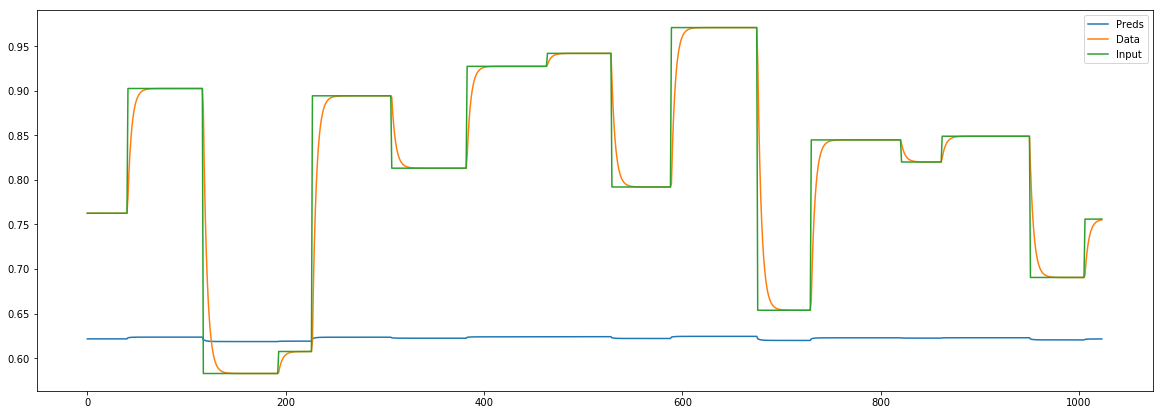

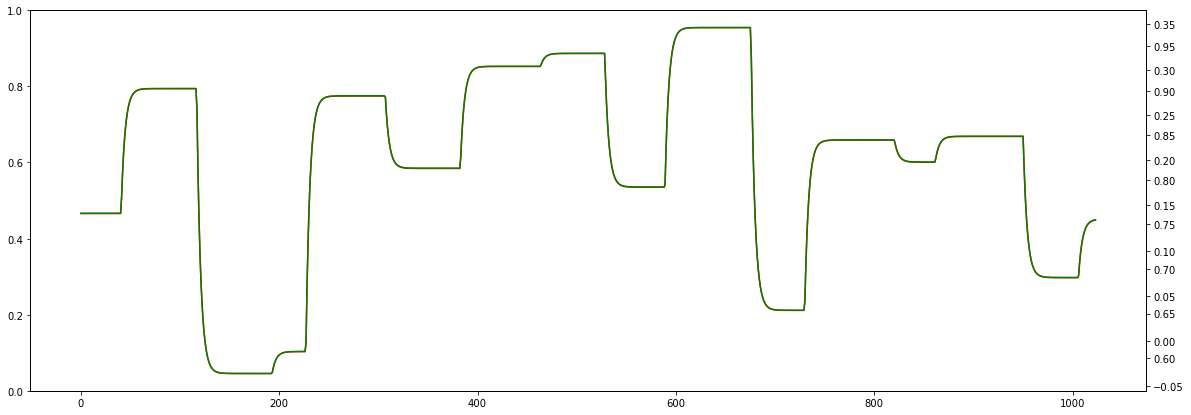

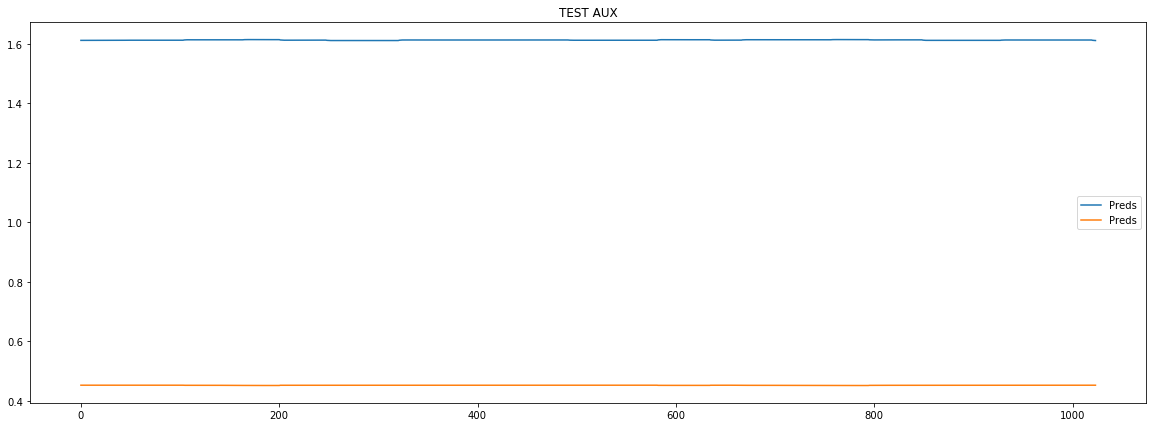

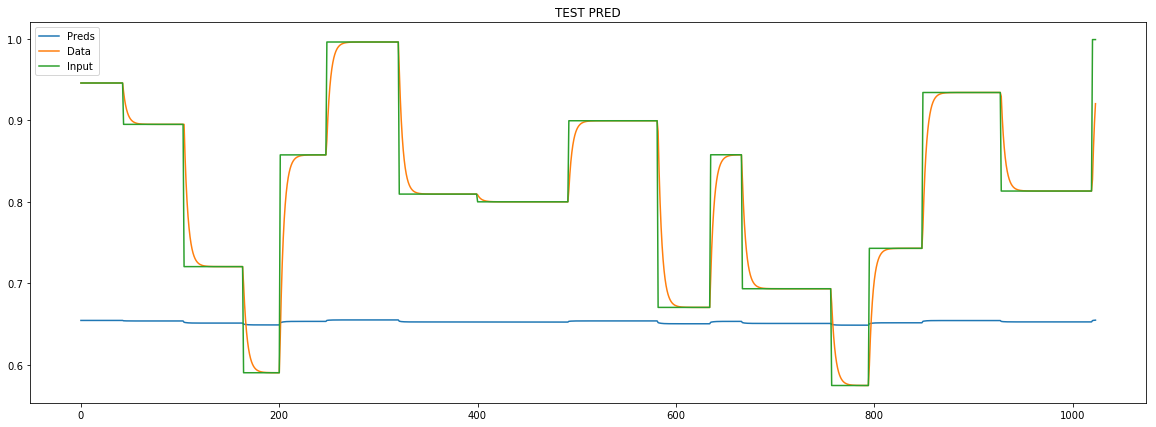

 Epoch [1]     
 train_loss[0.0]     
 eval_train[0.0]     
 eval_test[0.0] 



aux preds: 1.726344347000122 0.6571478247642517
aux loss 0.043350728730169624
const loss 0.0005051160334495272
main loss 0.0
combined loss 0.04385584476361915 


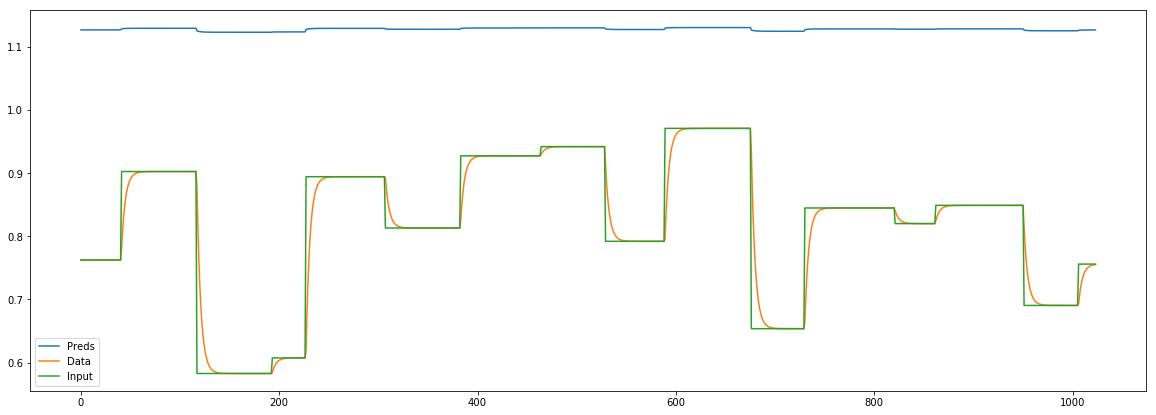

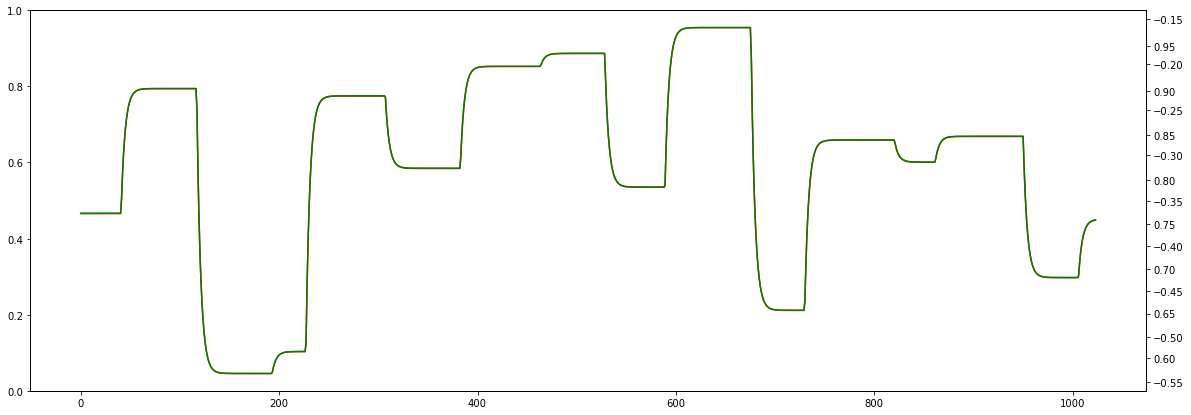

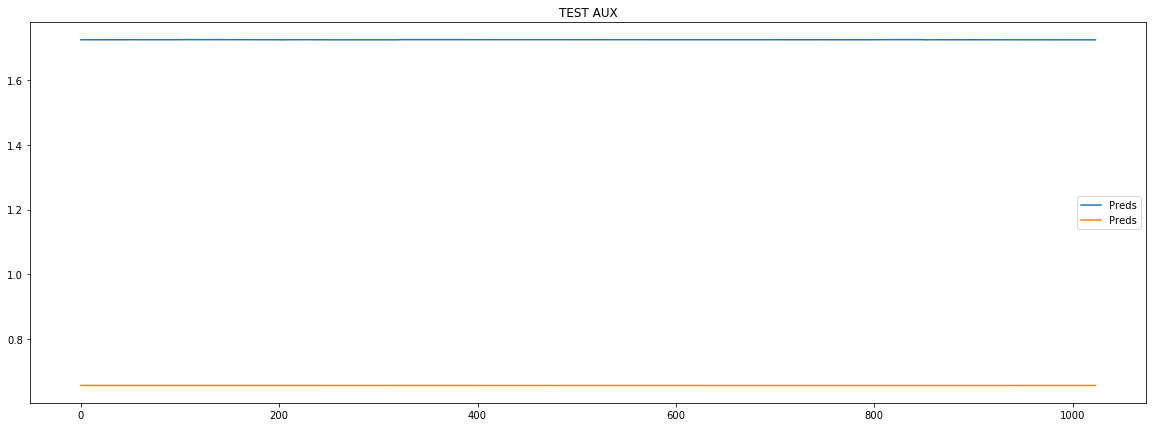

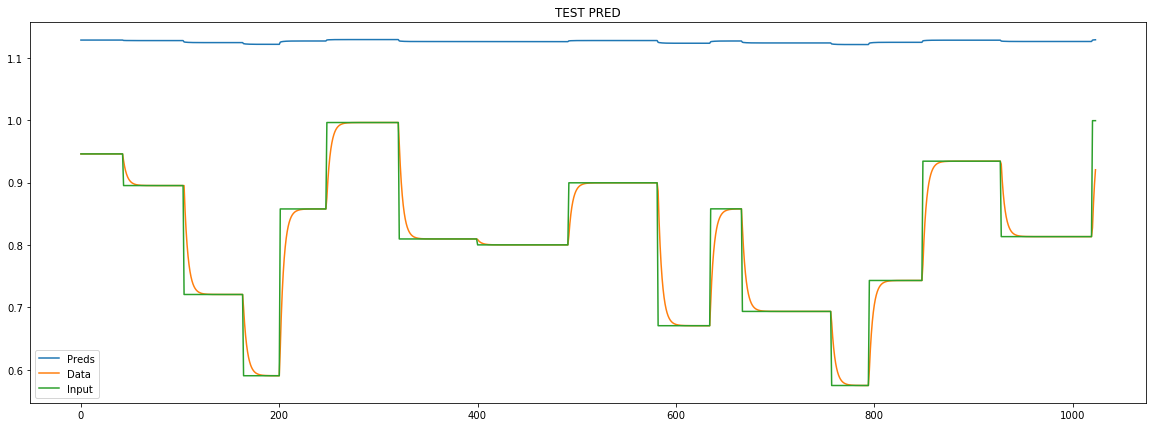

 Epoch [2]     
 train_loss[0.0]     
 eval_train[0.0]     
 eval_test[0.0] 



aux preds: 1.6807868480682373 0.6694426536560059
aux loss 0.04071387784698835
const loss 3.4886996602905965e-05
main loss 0.0
combined loss 0.04074876484359126 


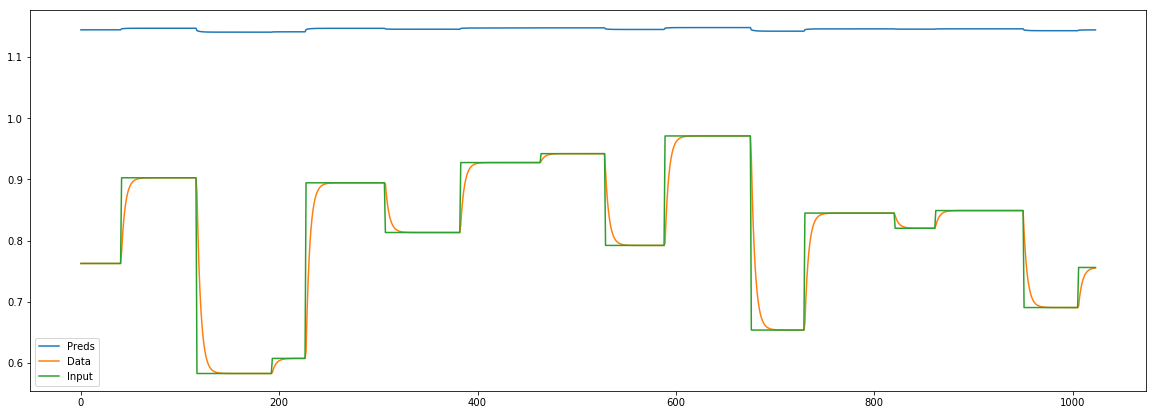

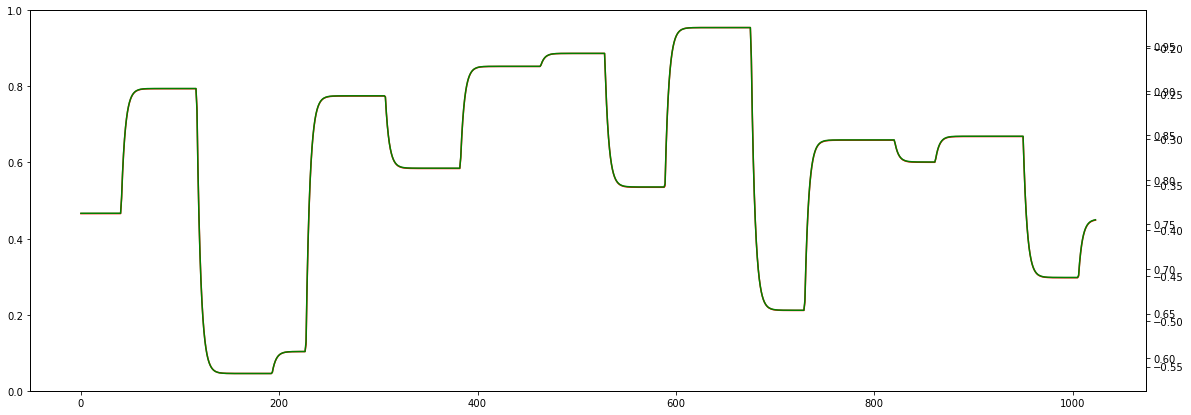

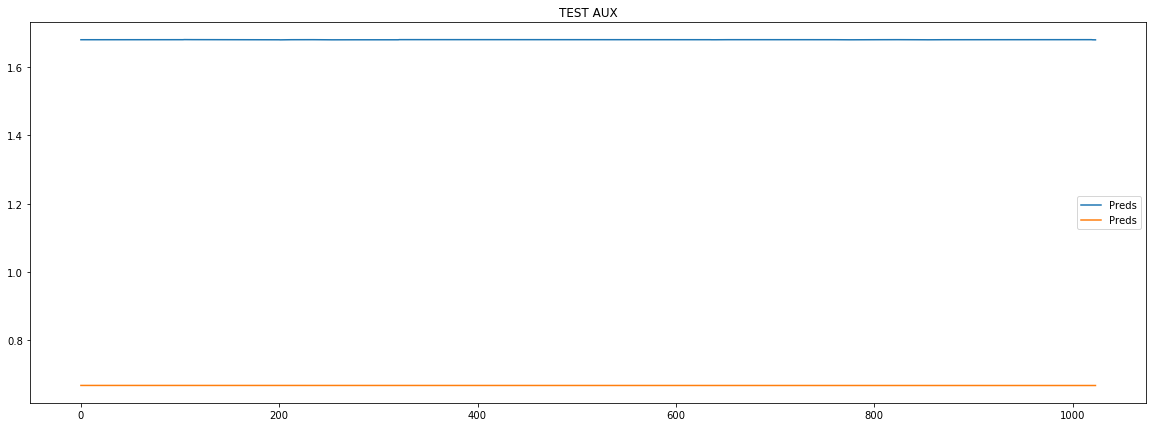

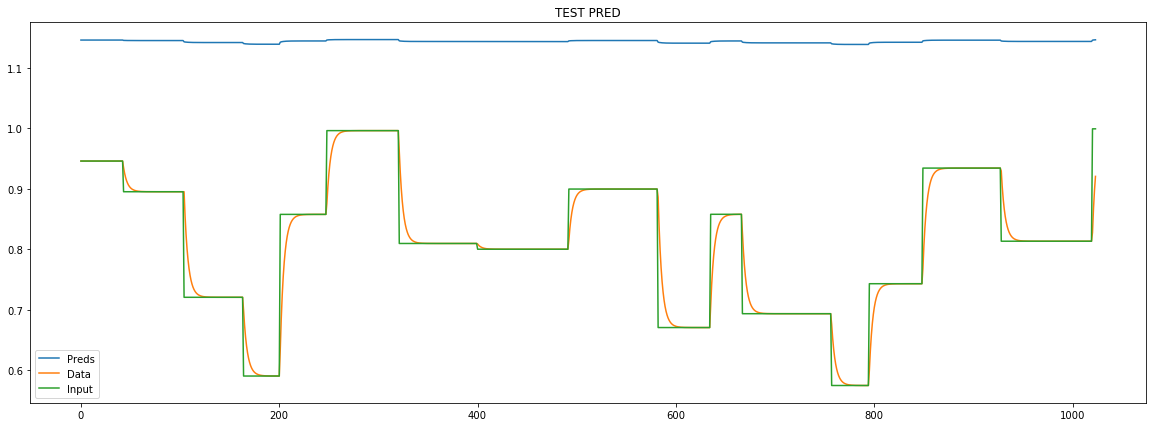

 Epoch [3]     
 train_loss[0.0]     
 eval_train[0.0]     
 eval_test[0.0] 



aux preds: 1.6256805658340454 0.6713464260101318
aux loss 0.04024138403698229
const loss 4.103622247314958e-05
main loss 0.0
combined loss 0.04028242025945544 


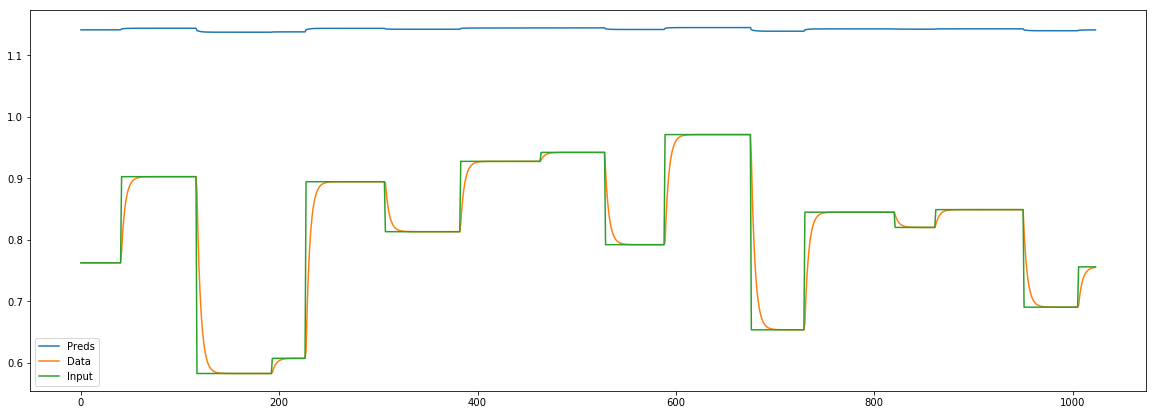

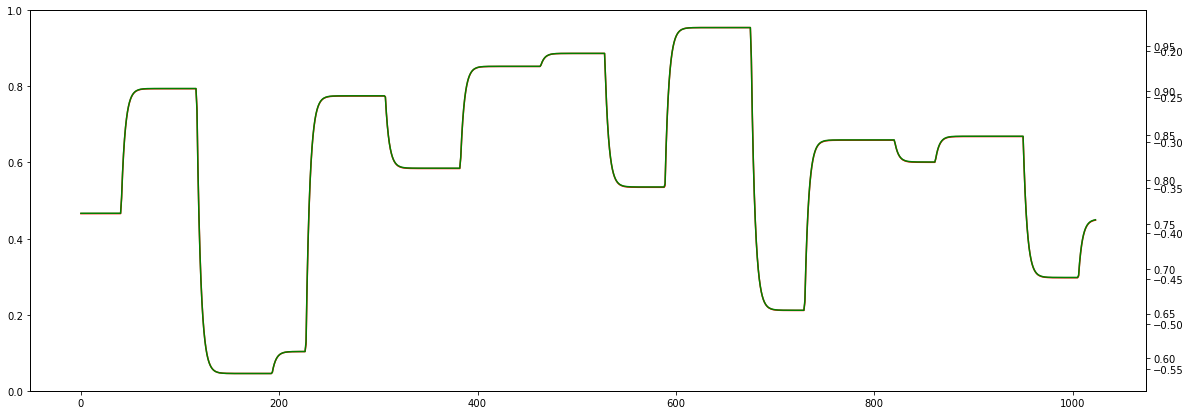

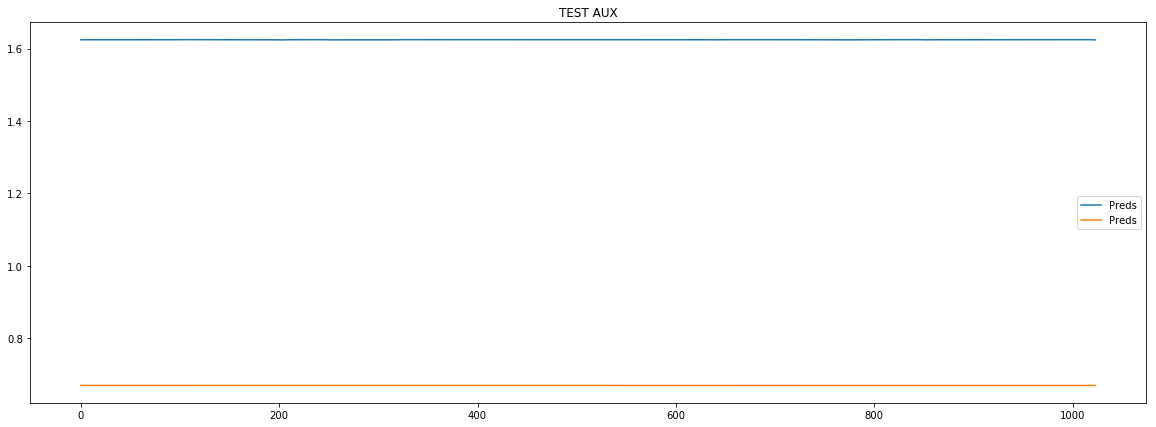

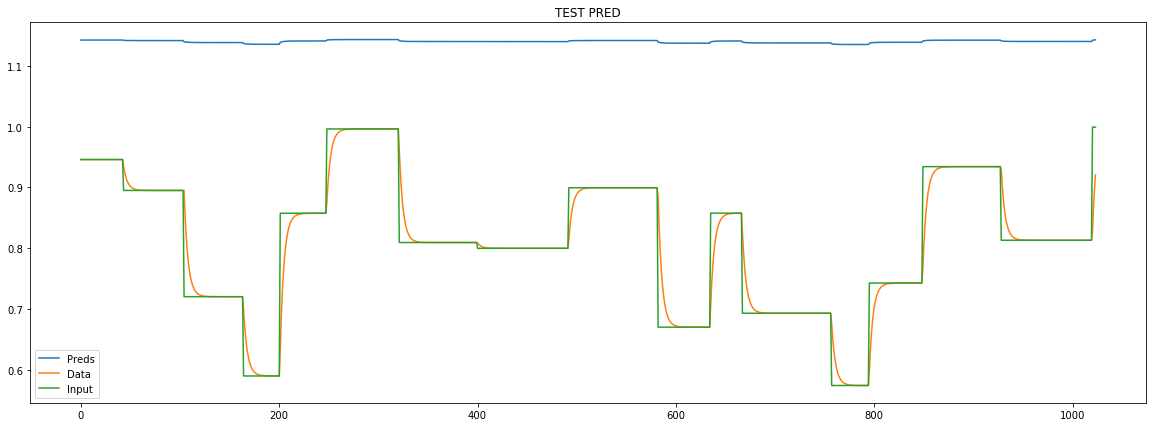

loss rate [nan]
 Epoch [4]     
 train_loss[0.0]     
 eval_train[0.0]     
 eval_test[0.0] 


/home/dkushn/miniconda3/envs/dkushn_dyploma/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in double_scalars



aux preds: 1.5646355152130127 0.6715400815010071
aux loss 0.039609381570838965
const loss 4.804744199086249e-05
main loss 0.0
combined loss 0.03965742901282983 


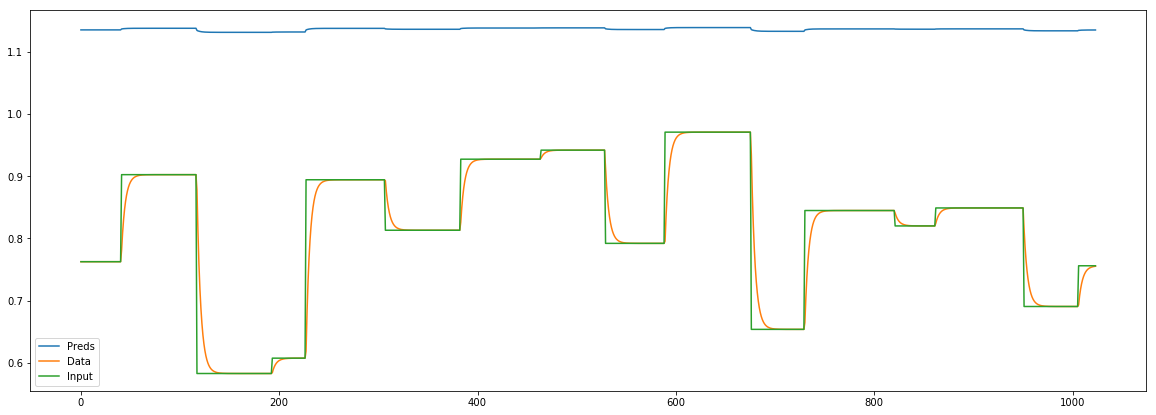

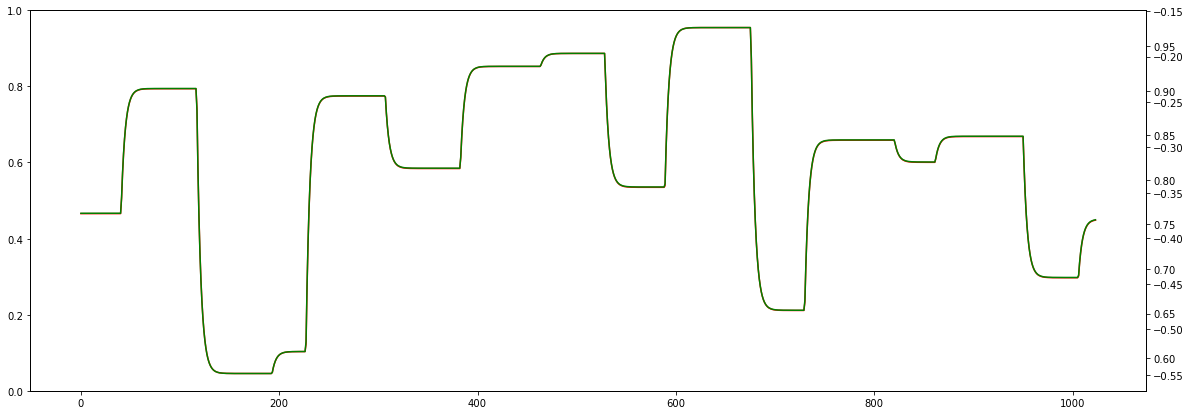

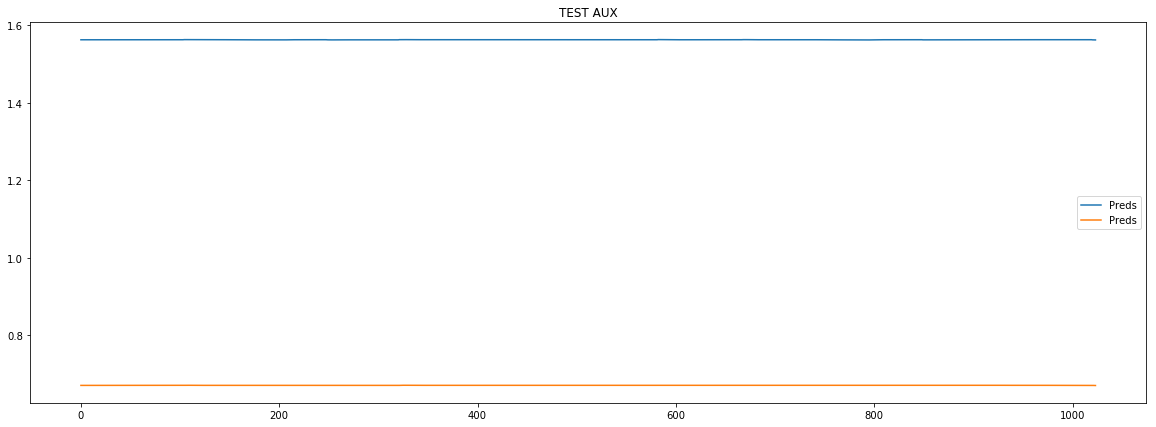

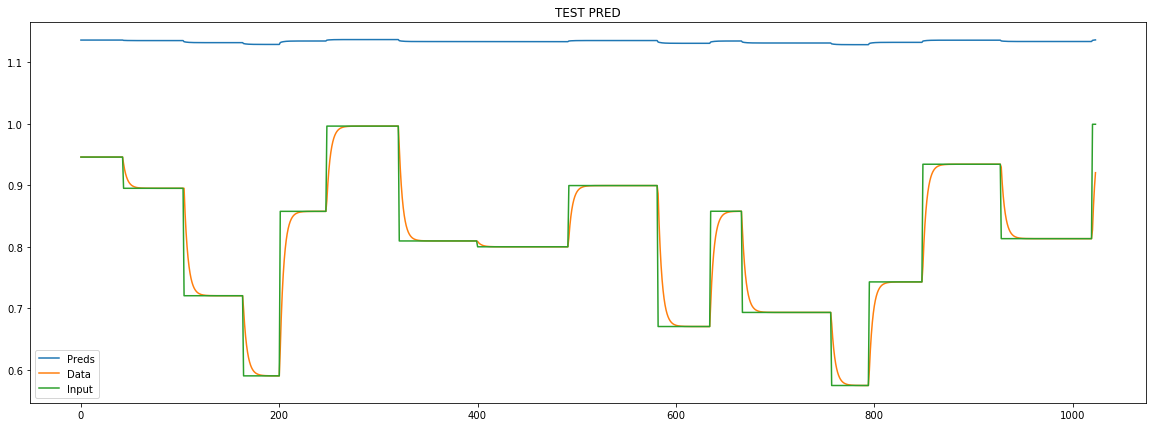

loss rate [nan]
 Epoch [5]     
 train_loss[0.0]     
 eval_train[0.0]     
 eval_test[0.0] 


KeyboardInterrupt: 

In [10]:
logging.info("Training process STARTED")

model.hidden = model.init_hidden()

lr_drop_rate = p_train['lr_drop_rate']
auto_loss = p_train['auto_loss']
if auto_loss:
    decrease_lr_epochs = p_train['drop_lr_each']

for t in range(num_epochs):

    if not auto_loss and t % decrease_lr_epochs == 0 and t != 0:
            lr /= lr_drop_rate
            print(f"LR UPDATED: {lr}")
            optimiser = torch.optim.Adam(model.parameters(), lr=lr)
            
    for i, data in enumerate(tqdm(train_dl)):
        x_batch, y_batch, indexes = data
        x_batch.transpose_(0, 1) # todo get rid of it
        model.hidden = model.init_hidden()

        y_pred = model(x_batch)
        losses = loss_fn(y_pred, y_batch, x_batch, config)
        main_loss, aux_loss, const_loss = losses
        losses = [aux_loss, const_loss]
#         print(f"losses before scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")
        max_loss = max(losses)
#         while max_loss < 1:
#             max_loss *= 10
            
#         for loss in losses:
#             while loss / max_loss < 0.1:
#                 loss *= 10
        
        combined_loss = sum(losses)
#         combined_loss *= 100
        
#         main_loss /= 10
        optimiser.zero_grad()
        
        combined_loss.backward()
        
#         print(f"losses after scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")
        
        optimiser.step()
        
        hist['train_local_loss'][i] = main_loss.item()
        hist['const']['train_local_loss'][i] = const_loss.item()
        hist['aux']['train_local_loss'][i] = aux_loss.item() 
        
    hist['preds']['1'][t] =torch.mean(y_pred[:, 1]) 
    hist['preds']['2'][t] =torch.mean(y_pred[:, 2]) 

    print(f"aux preds: {torch.mean(y_pred[:, 1])} {torch.mean(y_pred[:, 2])}")
    print(f"aux loss {np.average(hist['aux']['train_local_loss'])}")
    print(f"const loss {np.average(hist['const']['train_local_loss'])}")
    print(f"main loss {np.average(hist['train_local_loss'])}")
    print(f"combined loss {np.average(hist['aux']['train_local_loss']) + np.average(hist['const']['train_local_loss']) +  np.average(hist['train_local_loss'])} ")

    plot_shared_scale([
        (y_pred[:, 0].detach().numpy(),"Preds" ),
         (y_batch[:, 0].detach().numpy(), "Data"),
         (x_batch[-1].detach().numpy(), "Input")
        ])
    residuals = y_batch[:, 0] - y_pred[:, 0]
    plot_multiscale([
        (residuals.detach().numpy(), "Red"),
        (y_batch[:, 0].detach().numpy(), "Green")
    ]) 

          
    with torch.no_grad():
        model = model.eval()
        for i, data in enumerate(tqdm(train_dl)):
            x_batch, y_batch, indexes = data
            x_batch.transpose_(0, 1)
            y_pred = model(x_batch)
          
            loss = loss_fn(y_pred, y_batch, x_batch, config)
            main_loss, aux_loss, const_loss = loss

            hist['eval_train_local'][i] = main_loss.item()
            hist['const']['eval_train_local'][i] = const_loss.item()
            hist['aux']['eval_train_local'][i] = aux_loss.item()
          
        for i, data in enumerate(tqdm(test_dl)):
            x_batch_test, y_batch_test, indexes = data
            x_batch_test.transpose_(0, 1)
          
            y_pred_test = model(x_batch_test)
            loss = loss_fn(y_pred_test, y_batch_test, x_batch_test, config)
            main_loss, aux_loss, const_loss = loss
          
            
            hist['eval_test_local'][i] = main_loss.item()
            hist['const']['eval_test_local'][i] = const_loss.item()
            hist['aux']['eval_test_local'][i] = aux_loss.item()
          
        model = model.train()


    plot_shared_scale([
            (y_pred_test[:, 1].detach().numpy(),"Preds" ),
            (y_pred_test[:, 2].detach().numpy(),"Preds" ),
    ], title = 'TEST AUX')
    plot_shared_scale([
            (y_pred_test[:, 0].detach().numpy(),"Preds" ),
             (y_batch_test[:, 0].detach().numpy(), "Data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ],
        title = 'TEST PRED'
    )


#     residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
#     plot_multiscale(
#             [
#                 (residuals.detach().numpy(), "Red"), 
#              (y_batch_test[:, 0].detach().numpy(),"Green")
#             ],
#         title = 'TEST RESID'
#     )
    
          
    logging.info(f"Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_traiDn[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] ")

                 
    hist["train_loss"][t] = np.average(hist["train_local_loss"])
    hist["eval_train"][t] = np.average(hist["eval_train_local"])
    hist["eval_test"][t] = np.average(hist["eval_test_local"])
    hist['aux']['eval_test'][t] = np.average(hist['aux']['eval_test_local'])
    hist['aux']['eval_train'][t] = np.average(hist['aux']['eval_train_local'])
    hist['aux']['train_loss'][t] = np.average(hist['aux']['train_local_loss'])
    hist['const']['eval_test'][t] = np.average(hist['const']['eval_test_local'])
    hist['const']['eval_train'][t] = np.average(hist['const']['eval_train_local'])
    hist['const']['train_loss'][t] = np.average(hist['const']['train_local_loss'])
    
                 
    if t > 3:
        loss_rate = 1 - hist["eval_test"][t] / np.mean(hist["eval_test"][t-3:t])
        print(f"loss rate [{loss_rate}]")

        if auto_loss:
            loss_oscilates = hist["eval_test"][t] > hist["eval_test"][t-1]
            if loss_oscilates:
                 print(f"oscilation: t:[{hist['eval_test'][t]}] > t-1:[{hist['eval_test'][t-1]}]")
            loss_stops = loss_rate < 0.01
            if loss_stops:
                print(f"loss stopped: loss drop= [{loss_rate}]")
            if loss_oscilates or loss_stops:
                lr /= lr_drop_rate
                print()
                print(f"LR UPDATED: {lr}")
                print()
                if lr <= 1/10**7:
                    print(f"learning rate critically low [{lr}] PRELIMINAR STOPPING")
                    break
                optimiser = torch.optim.Adam(model.parameters(), lr=lr)
        
                 
    msg = f" Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_train[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] "
    
    print(msg)
    logging.info(msg)

In [ ]:
auto_loss

In [ ]:
s, e = 1, -1
plot_shared_scale([
    (hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")
])

In [ ]:
s, e = 2, -1
plot_shared_scale([
    (hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test"),
#                   (hist['aux']['train_loss'][s:e], "aux_train"),
#                   (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
#                   (hist['aux']['eval_test'][s:e], "aux_Eval_test")
])

In [ ]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")])

In [ ]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['const']['train_loss'][s:e], "const_aux_train"),
                  (hist['const']['eval_train'][s:e], "const_aux_Eval_train"),
                  (hist['const']['eval_test'][s:e], "const_aux_Eval_test")])

In [ ]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['preds']['1'][s:e], "p1"),
                  ((hist['preds']['2']*0 + 1)[s:e], "p2"),
                  (hist['preds']['2'][s:e], "p2"),
                  ((hist['preds']['2']*0 + 0.5)[s:e], "p2"),
#                   (hist['const']['eval_test'][s:e], "const_aux_Eval_test")
])

In [ ]:
model.buffers

In [ ]:
logging.info("Training process END")

In [ ]:
? torch.nonzero

In [ ]:
? torch.where

In [ ]:
resid = torch.abs(a[1:] - a[:-1])

In [ ]:
resid.max()

In [ ]:
d = torch.where(resid > 0.000001, resid, resid * 0)

In [ ]:
indexes = d.nonzero()

In [ ]:
elems = resid[indexes[:, 0]]
len(elems)

In [ ]:
elems.mean()

In [ ]:
a = y_batch[:, 0].unsqueeze(1)
a = torch.abs(a)
b = torch.where(a<0+0.001 , a, a * 0 + 1)

In [ ]:
plt.plot(a.detach().numpy())
plt.plot(b.detach().numpy())